In [ ]:
!pip install tensorflow-text

In [2]:
!pip install -q tf-models-official

In [3]:
import os 
import shutil 

import tensorflow as tf 
import tensorflow_hub as hub 
import tensorflow_text as text 
from official.nlp import optimization 

import matplotlib.pyplot as plt 

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [4]:
# Enable GPU 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

In [5]:
# This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review

In [6]:
# Download and extract the dataset.

url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 3s 0us/step


Next, you will use the 'text_dataset_from_directory' utility to create a labeled 'tf.data.Dataset'.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. 
Let's create a validation set using an 80:20 split of the training data by using the 'validation_split' argument below.

Note: When using the 'validation_split' and 'subset' arguments, make sure to either specify a random seed, or to pass 'shuffle=False', so that the validation and training splits have no overlap.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32 
seed = 42 

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

class_names = raw_train_ds.class_names

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [8]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})')
        print('-------------------------------------------')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
-------------------------------------------
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characte

In [9]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [10]:
# bring/fetch preprocessing model
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

# text_test == Example sentence
text_test = ['this is such an amazing movie!']  # ! is also a token.

# preprocessing 
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print()
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')  # sentence length is fixed to 128. 128==seq_length
print()
print(f'Word Ids   : {text_preprocessed["input_word_ids"]}')
print()
print(f'Input Mask : {text_preprocessed["input_mask"]}')    # 값 1 at the position of all input tokens. 값 0 for the padding tokens.
print()
print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')    # the input_type_ids only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']

Shape      : (1, 128)

Word Ids   : [[ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]

Input Mask : [[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 

In [11]:
# bring/fetch bert model 
bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

In [12]:
bert_results.keys()

dict_keys(['default', 'encoder_outputs', 'sequence_output', 'pooled_output'])

In [13]:
print(f'Loaded BERT: {tfhub_handle_encoder}')

print()
print(f'Encoder Output Length:{len(bert_results["encoder_outputs"])}')

print()
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')    # pooled output is the embedding of [CLS] token. In general, people use pooled_output of the sentence and use it for text classification
                                                                        # pooled_output represents each input sequence as a whole. The shape is [batch_size, H]. You can think of this as an embedding for the entire movie review.
print()
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')    # sequence_output represents each input token in the context. 
                                                                            # The shape is [batch_size, seq_length, H]. You can think of this as a "contextual embedding for every token" in the movie review.

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4

Encoder Output Length:12

Pooled Outputs Shape:(1, 768)

Sequence Outputs Shape:(1, 128, 768)


In [14]:
# define model 
# create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

In [18]:
def build_classifier_model():
    # define layers
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = preprocessing_layer(text_input)   
    outputs = encoder(encoder_inputs)

    net = tf.keras.layers.Dropout(0.1)(outputs['pooled_output'])
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)

    return tf.keras.Model(text_input, net)

In [19]:
classifier_model = build_classifier_model()

bert_raw_result = classifier_model(tf.constant(text_test))  # input text_test

print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.35095608]], shape=(1, 1), dtype=float32)


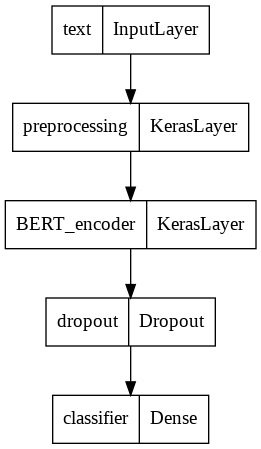

In [20]:
tf.keras.utils.plot_model(classifier_model)

### Model Training

In [21]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [22]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [23]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [24]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Epoch 1/5
625/625 [==============================] - 645s 1s/step - loss: 0.4086 - binary_accuracy: 0.7972 - val_loss: 0.2985 - val_binary_accuracy: 0.8768
Epoch 2/5
625/625 [==============================] - 628s 1s/step - loss: 0.2246 - binary_accuracy: 0.9058 - val_loss: 0.3550 - val_binary_accuracy: 0.8796
Epoch 3/5
625/625 [==============================] - 628s 1s/step - loss: 0.1206 - binary_accuracy: 0.9578 - val_loss: 0.4515 - val_binary_accuracy: 0.8874
Epoch 4/5
625/625 [==============================] - 621s 994ms/step - loss: 0.0586 - binary_accuracy: 0.9841 - val_loss: 0.5661 - val_binary_accuracy: 0.8790
Epoch 5/5
625/625 [==============================] - 623s 997ms/step - loss: 0.0303 - binary_accuracy: 0.9923 - val_loss: 0.6378 - val_binary_accuracy: 0.8852


In [25]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 274s 350ms/step - loss: 0.6195 - binary_accuracy: 0.8843
Loss: 0.6195390820503235
Accuracy: 0.8843200206756592


In [26]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [27]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

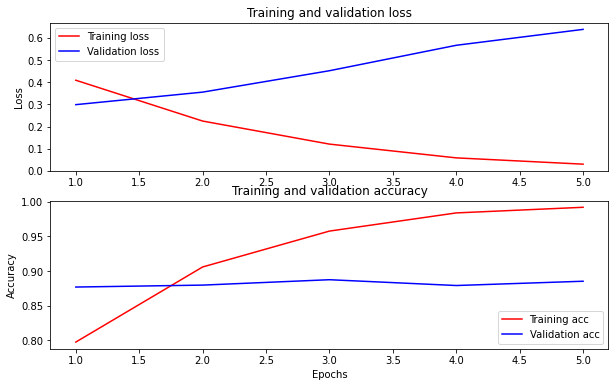

In [28]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [29]:
# Export for inference
# Save the fine-tuned model for later use

dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [30]:
# Reload the model 
reloaded_model = tf.saved_model.load(saved_model_path)

In [31]:
def print_my_examples(inputs, results):
    result_for_printing = [f'input: {inputs[i]:<30} -> score: {results[i][0]:.6f}' for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()

In [32]:
examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

In [33]:
reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)

print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! -> score: 0.997083
input: The movie was great!           -> score: 0.994246
input: The movie was meh.             -> score: 0.718662
input: The movie was okish.           -> score: 0.092181
input: The movie was terrible...      -> score: 0.000366

Results from the model in memory:
input: this is such an amazing movie! -> score: 0.997083
input: The movie was great!           -> score: 0.994246
input: The movie was meh.             -> score: 0.718662
input: The movie was okish.           -> score: 0.092181
input: The movie was terrible...      -> score: 0.000366

